# Shelter Outcomes

In [27]:
library(dplyr)
library(tidyr)
library(purrr)
library(ggplot2)
library(readr)
library(lubridate)
library(stringr)
library(randomForest)
library(caret)
options(repr.plot.width = 6)
options(repr.plot.height = 4)

We are given a dataset from the Austin Animal Center with pet intake information. The goal is to predict the outcome for each animal to help the shelter identify which specific animals could use extra focus to help ensure a positive outcome.

Lets first read in the datasets and combine into a single DataFrame. These datasets are provided by [Kaggle](https://www.kaggle.com/c/shelter-animal-outcomes/). We will also convert columns to more useful types.

In [2]:
train <- read_csv('Data/train.csv')
train$AnimalID <- NULL
train$OutcomeSubtype <- NULL

final <- read_csv('Data/test.csv')
df <- bind_rows(train, final)

df$AnimalType <- as.factor(df$AnimalType)
df$OutcomeType <- as.factor(df$OutcomeType)
df$SexuponOutcome <- as.factor(df$SexuponOutcome)
df$Age <- df$AgeuponOutcome
df$AgeuponOutcome <- NULL

Parsed with column specification:
cols(
  AnimalID = col_character(),
  Name = col_character(),
  DateTime = col_datetime(format = ""),
  OutcomeType = col_character(),
  OutcomeSubtype = col_character(),
  AnimalType = col_character(),
  SexuponOutcome = col_character(),
  AgeuponOutcome = col_character(),
  Breed = col_character(),
  Color = col_character()
)
Parsed with column specification:
cols(
  ID = col_integer(),
  Name = col_character(),
  DateTime = col_datetime(format = ""),
  AnimalType = col_character(),
  SexuponOutcome = col_character(),
  AgeuponOutcome = col_character(),
  Breed = col_character(),
  Color = col_character()
)


In [3]:
paste('Training set size: ', nrow(train))
paste('Test set size: ', nrow(final))

[1] "Training set size:  26729"

[1] "Test set size:  11456"

## Feature Extraction
Lets look to see if there are any features we can pull out of the fields we have. Starting with *SexuponOutcome*, we see levels that have gender and spayed/neutered combined. We can pull them out into two separate columns.

In [4]:
levels(df$SexuponOutcome)

[1] "Intact Female" "Intact Male"   "Neutered Male" "Spayed Female"
[5] "Unknown"

In [5]:
df$Sex <- ifelse(str_detect(df$SexuponOutcome, 'Male'), 'Male', 'Female')
df$Sex <- as.factor(df$Sex)
df$Intact <- ifelse(str_detect(df$SexuponOutcome, 'Intact'), 'Intact', 'Fixed')
df$Intact <- as.factor(df$Intact)
df$SexuponOutcome <- NULL

The name field is going to be too difficult to use as is. We can simply this to a feature of whether a name was given or not. It seems plausible that pets with names might have different outcomes then pets without names.

In [6]:
df$NamePresent <- ifelse(!is.na(df$Name), 'Name', 'No Name')
df$NamePresent <- as.factor(df$NamePresent)
df$Name <- NULL

Looking at *Age* we see that it is given as a strings in the format of a number and a timespan. We will need to split these strings and pull out the two components.

In [7]:
head(df$Age)

[1] "1 year"  "1 year"  "2 years" "3 weeks" "2 years" "1 month"

In [8]:
df$Age <- map_dbl(df$Age, function(s){
  if (is.na(s)) {return(NA)} 
  v <- strsplit(s, ' ')[[1]]
  scale <- c(1, 12, 52, 365)
  as.numeric(v[[1]])/scale[which(str_detect(v[[2]], c('year', 'month', 'week', 'day')))]})

The time field is given as a full timestamp. Lets see if the evaluation set is randomly dispered or if it occurs after the training set in time.

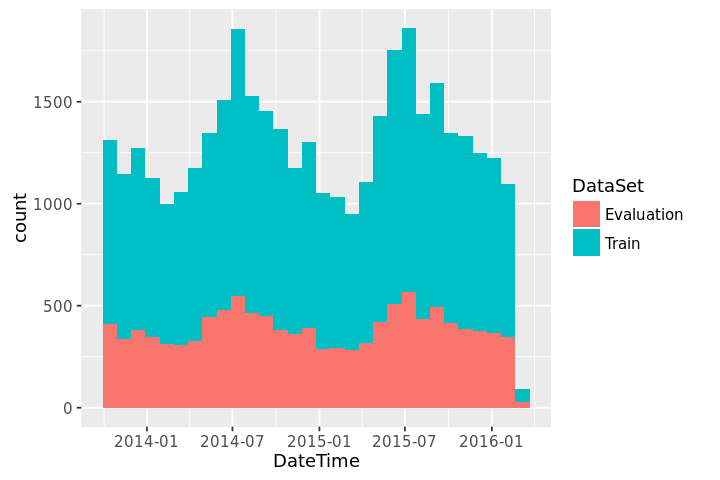

In [9]:
df %>% mutate(DataSet = factor(is.na(ID), labels=c('Evaluation', 'Train'))) %>%  
  ggplot(aes(x=DateTime, fill=DataSet)) +
  geom_histogram(bins=30)

We see that the the evaluation set is chosen from the same time span with approximately the same distribution. We also only see periodic changes in the number of pets processed (on the year period). Lets now check if there are any trends in outcomes over time.


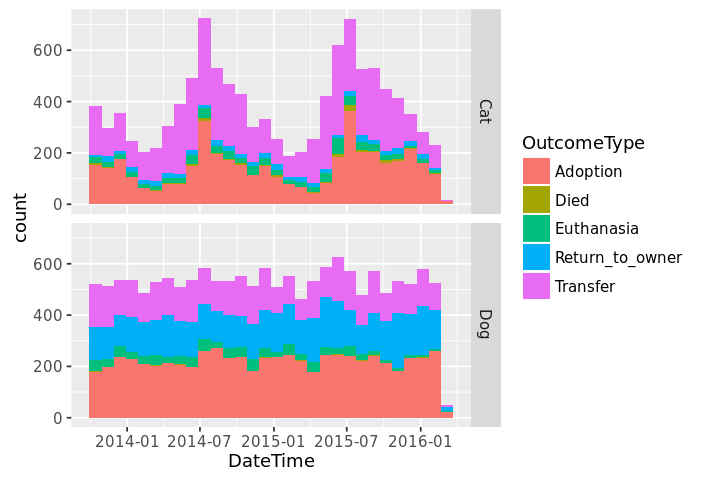

In [10]:
df %>% filter(is.na(ID)) %>% 
  ggplot(aes(x=DateTime, fill=OutcomeType)) +
  geom_histogram(position='stack', bins=30) + facet_grid(AnimalType~.)

Interestingly, we see almost no change in dog outcomes, but significant periodicity in cat outcomes. It seems that many more cats are processed in the summer. We also see no significant long term trends in outcomes, letting us use only periodic time features. We will make hour of day, day of week, and month features.

In [11]:
df <- df %>% mutate(WeekDay = wday(DateTime),
                    Hour = hour(DateTime),
                    Month = month(DateTime))

Moving onto breed, we have the challenge of a huge number of factors. We see 1380 distinct breed values. However, looking at the first couple results, we also see a significant number that are tagged as 'Mix'. We can pull that into it's own column as a logical and see how this affects ours distinct breed count.

In [12]:
paste('Number of unique breeds:', length(unique(df$Breed)))
head(df$Breed, n=10)
df$Mix <- str_detect(df$Breed, 'Mix')
df$BreedNoMix <- str_replace(df$Breed, ' Mix', '')
paste("Number of unique breeds ('Mix' removed):", length(unique(df$BreedNoMix)) )

[1] "Number of unique breeds: 1678"

[1] "Shetland Sheepdog Mix"             "Domestic Shorthair Mix"           
 [3] "Pit Bull Mix"                      "Domestic Shorthair Mix"           
 [5] "Lhasa Apso/Miniature Poodle"       "Cairn Terrier/Chihuahua Shorthair"
 [7] "Domestic Shorthair Mix"            "Domestic Shorthair Mix"           
 [9] "American Pit Bull Terrier Mix"     "Cairn Terrier"

[1] "Number of unique breeds ('Mix' removed): 1527"

We are still left with far too many breeds. We will take the top 15 breeds for cats and dogs and put everything else into an 'Other' category. 

In [13]:
breed_count <- df %>%
  group_by(AnimalType) %>%
  count(BreedNoMix, sort=T)

top_cat <- subset(breed_count, AnimalType=='Cat')
top_dog <- subset(breed_count, AnimalType=='Dog')
head(top_cat, n=15)
head(top_dog, n=15)

top_breeds <- c(top_dog[1:15,]$BreedNoMix, top_cat[1:15,]$BreedNoMix)

df$BreedTop <- df$BreedNoMix
df$BreedTop[!(df$BreedNoMix %in% top_breeds)] <- 'Other'
df$BreedTop <- as.factor(df$BreedTop)

AnimalType,BreedNoMix,n
Cat,Domestic Shorthair,12781
Cat,Domestic Medium Hair,1284
Cat,Domestic Longhair,780
Cat,Siamese,599
Cat,Snowshoe,110
Cat,Maine Coon,71
Cat,Manx,60
Cat,Russian Blue,47
Cat,Himalayan,25
Cat,Ragdoll,20


AnimalType,BreedNoMix,n
Dog,Pit Bull,2877
Dog,Chihuahua Shorthair,2623
Dog,Labrador Retriever,2059
Dog,German Shepherd,925
Dog,Australian Cattle Dog,554
Dog,Dachshund,507
Dog,Boxer,378
Dog,Miniature Poodle,365
Dog,Border Collie,347
Dog,Australian Shepherd,274


For color, we have a similar problem of too many levels. However, it seems that a lot of observations have multple colors separated by a '/'. We will break these apart and just use the color to the left of the '/'. This drops some information but makes our lives a little easier (allowing each row to have multiple colors would mean we could no longer store it in a single column of type factor).

In [14]:
df$BasicColour <- str_split_fixed(df$Color, '/', n=2)[,1]
df$BasicColour <- str_split_fixed(df$BasicColour, ' ', n=2)[,1]
df$BasicColour <- as.factor(df$BasicColour)

## Data Filling
Our data is now looking much cleaner, but we stil have some missing data to deal with.

In [15]:
colSums(is.na(df))

DateTime OutcomeType  AnimalType       Breed       Color          ID 
          0       11456           0           0           0       26729 
        Age         Sex      Intact NamePresent     WeekDay        Hour 
         24           1           1           0           0           0 
      Month         Mix  BreedNoMix    BreedTop BasicColour 
          0           0           0           0           0

There seems to be one poor pet with a missing gender and spayed/neutered status. There are also a small amount of missing ages. Since this number is so small we will simply set it to the mean value for each feature. Now that our data is nicely formatted, we will assign our *df* dataframe to just the training observations and separate the evaluation observations into their own dataframe.

In [16]:
df$Sex[is.na(df$Sex)] <- count(df, vars=Sex, sort=T)[[1,1]]
df$Intact[is.na(df$Intact)] <- count(df, vars=Intact, sort=T)[[1,1]]
df$Age[is.na(df$Age)] <- mean(df$Age, na.rm=T)
evaluation <- filter(df, !is.na(ID))
df <- filter(df, is.na(ID))

## Data Exploration
Now that we have nicely formatted data we can continue with exploring it. Lets start by comparing overall outcomes between cats and dogs.

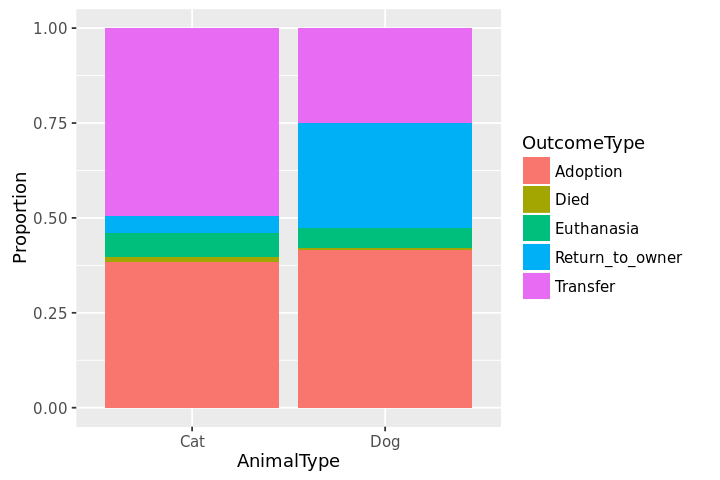

In [17]:
df %>% ggplot(aes(x=AnimalType, fill=OutcomeType)) +
  geom_bar(position='fill') + ylab('Proportion')

Adoption, death, and euthanasia rates are quite similar, but transfer and return to owner rates differ significantly between cats and dogs.

Looking at age we see a much younger population in cats. Very young cats may be more likely to end up in a shelter because they get lost while exploring their surrounds (since they are often not kept on leash like dogs). 

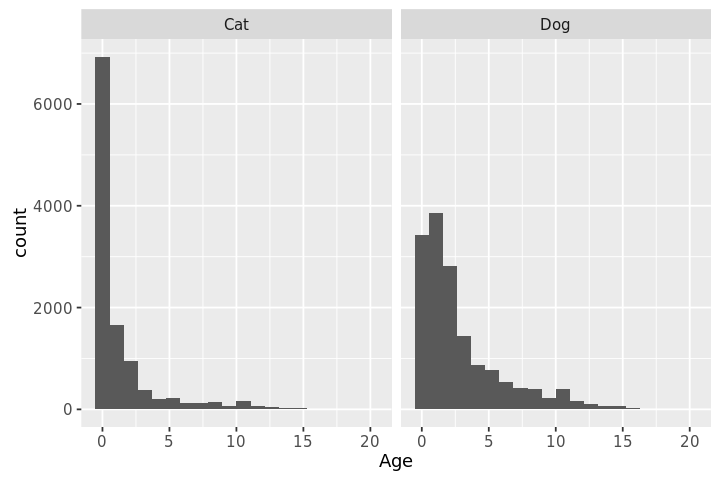

In [18]:
df %>% ggplot(aes(Age)) +
  geom_histogram(bins=20) + facet_grid(.~AnimalType)

We can now combine age and outcomes.

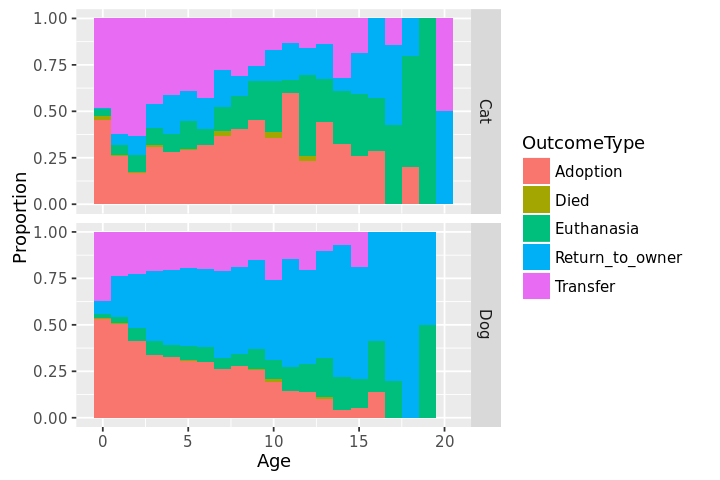

In [19]:
df %>% filter(!is.na(OutcomeType)) %>%
  ggplot(aes(Age, fill=OutcomeType)) +
  geom_histogram(position='fill', binwidth=1) +
  facet_grid(AnimalType~.) + ylab('Proportion')

Here we see some very interesting trends. Dogs become much less likely to be adopted as they age but much more likely to be returned to their owner. It seems that old dogs tend to run away from home! On the other hand, cats are much more likely to be transfered at a young age and the adoption percentage stays strong all the way into 15 years old. Already, these two features seem quite descriptive. Lets now make a set of exploratory plots using the other binary features: *Intact* and *NamePresent*.

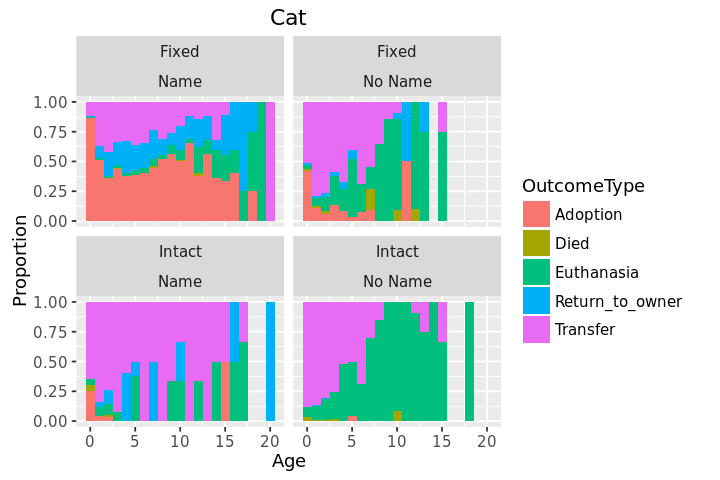

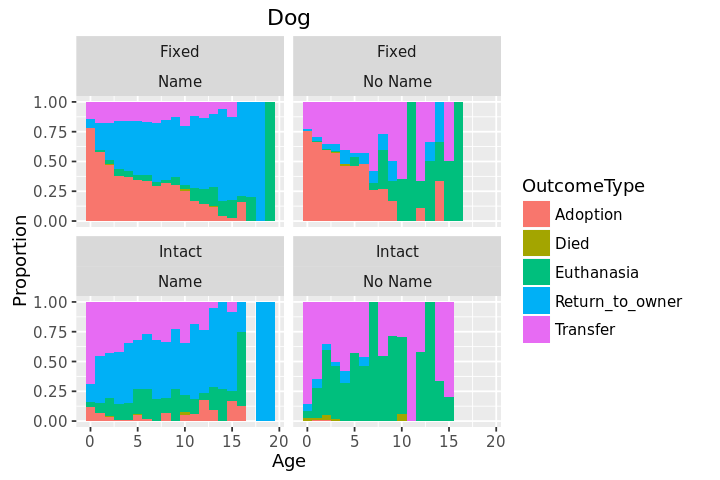

In [20]:
p <-df %>% group_by(AnimalType) %>% 
  do(plot=ggplot(data=.) +
  aes(x=Age, fill=OutcomeType) +
  geom_histogram(position='fill', binwidth=1) + 
  ylab('Proportion') +
  facet_wrap(~Intact + NamePresent) +
  ggtitle(unique(.$AnimalType)))
p[[1,2]]
p[[2,2]]

We see the saddening result that both cats and dogs without a name, intact and older in age, are much more likely to be euthanised. Dogs with a name are much more likely to be returned to their owner, which makes sense as the name and owner contact info are often found together on dog tags. Adoptions are also almost none existant for animals that are not fixed. Depending on the cost of fixing a pet this may be a worthwhile intervention for many pets entering the shelter.

Looking at the periodic time variables we made, we see some spikes in *Transfers* at specific points in time.

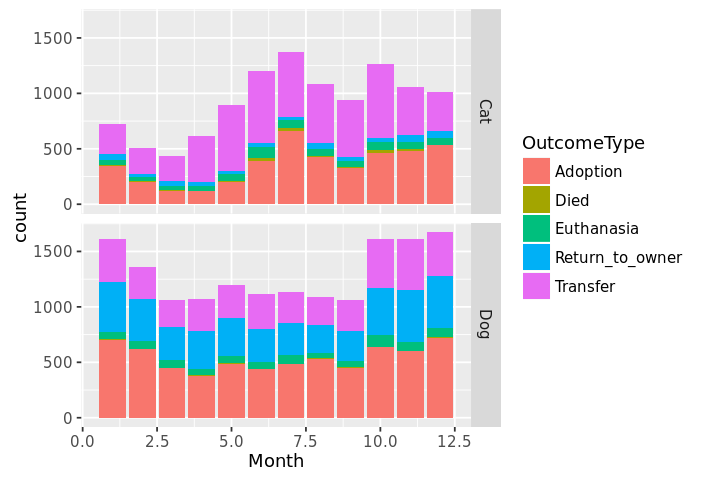

In [21]:
df %>% ggplot(aes(x=Month, fill=OutcomeType)) +
  geom_bar() + facet_grid(AnimalType~.)

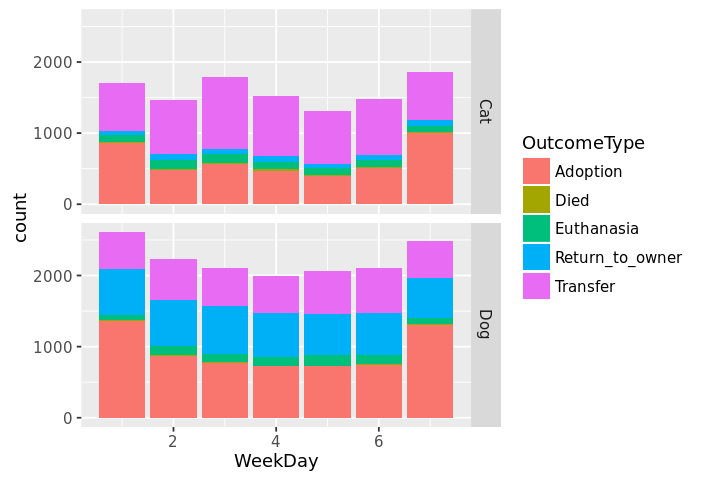

In [22]:
df %>% ggplot(aes(x=WeekDay, fill=OutcomeType)) +
  geom_bar() + facet_grid(AnimalType~.)

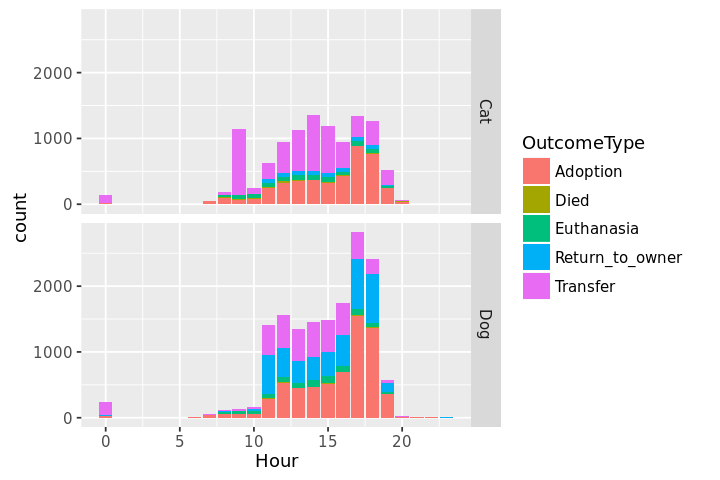

In [23]:
df %>% ggplot(aes(x=Hour, fill=OutcomeType)) +
  geom_bar() + facet_grid(AnimalType~.)

Looking at breeds, we see large changes in outcomes for cats. It even seems that no *American Shorthair* cats were adopted, although these may be from some noise as we the distribution in breeds amongst cats to drop off very quickly. For dogs we see a relatively flat distribution except for *Pit Bulls* which were significantly more likely to be euthanised.

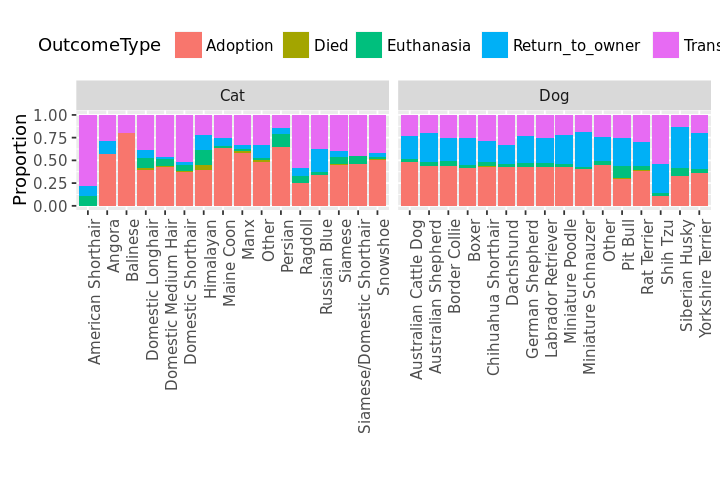

In [24]:
df %>% ggplot(aes(x=BreedTop, fill=OutcomeType)) +
  geom_bar(position='fill') + facet_grid(.~AnimalType, scales='free_x', space='free_x') +
  theme(axis.text.x=element_text(angle=90, hjust=1), legend.position='top') + 
  xlab('') + ylab('Proportion')

Since we didn't cut off color based on the top counts (like we did by breed), we will look at it in absolute numbers instead of proportions to so we don't get distracted by noise in smaller groups.

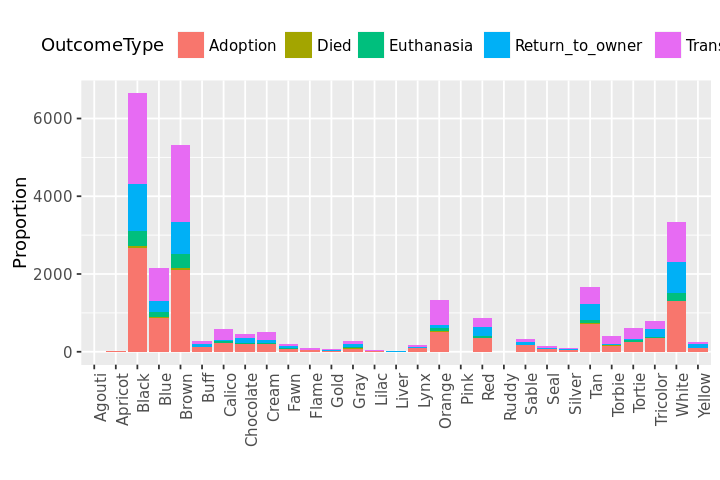

In [25]:
df %>% ggplot(aes(x=BasicColour, fill=OutcomeType)) +
  geom_bar() +
  theme(axis.text.x=element_text(angle=90, hjust=1), legend.position='top') + 
  xlab('') + ylab('Proportion')

## Model
Most of this exercise has been in the data cleaning and exploration. For our model we will use a straightforward random forest which can handle our large amount of factor features. Cross validation and some parameter tuning will be left for future exercises. We will use the Random Forest libraries OOB error estimate for now.

Finally, the evaluation set will also be predicted and saved to file.

In [26]:
tree <- randomForest(OutcomeType ~ AnimalType + Age + Sex + Intact +
                       NamePresent + Hour + Month + WeekDay + BasicColour +
                       BreedTop + Mix,
                       data=df)

prediction <- predict(tree, evaluation, type = 'vote')

solution <- data.frame('ID' = evaluation$ID, prediction)

conf <- tree$confusion[1:5,1:5]
paste('Accuracy: ', sum(diag(conf))/sum(conf))

write.csv(solution, 'Data/RandomForest.csv', row.names = F)

[1] "Accuracy:  0.683340192300498"